In [1]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
!tesseract --version

'tesseract' is not recognized as an internal or external command,
operable program or batch file.


Memulai proses dari folder: 'C:\Users\LENOVO\Downloads\statexplore\Data\C01\business_confidence_index and manufacturing_pmi'

[INFO] Memproses business_confidence_index and manufacturing_pmi tahun 2000.png...
  -> Tahun (OCR): 2000
  -> Sumbu Y (OCR): Min=5.0, Max=55.0
  -> Ditemukan 3255 titik data untuk 'business_confidence_index'
  -> Ditemukan 3478 titik data untuk 'manufacturing_pmi'

[INFO] Memproses business_confidence_index and manufacturing_pmi tahun 2001.png...
  -> Tahun (OCR): 2001
  -> Sumbu Y (OCR): Min=5.0, Max=475.0
  -> Ditemukan 3162 titik data untuk 'business_confidence_index'
  -> Ditemukan 3389 titik data untuk 'manufacturing_pmi'

[INFO] Memproses business_confidence_index and manufacturing_pmi tahun 2002.png...
  -> Tahun (OCR): 2002
  -> Sumbu Y (OCR): Min=3.0, Max=55.0
  -> Ditemukan 3345 titik data untuk 'business_confidence_index'
  -> Ditemukan 3478 titik data untuk 'manufacturing_pmi'

[INFO] Memproses business_confidence_index and manufacturing_pmi tahun 2

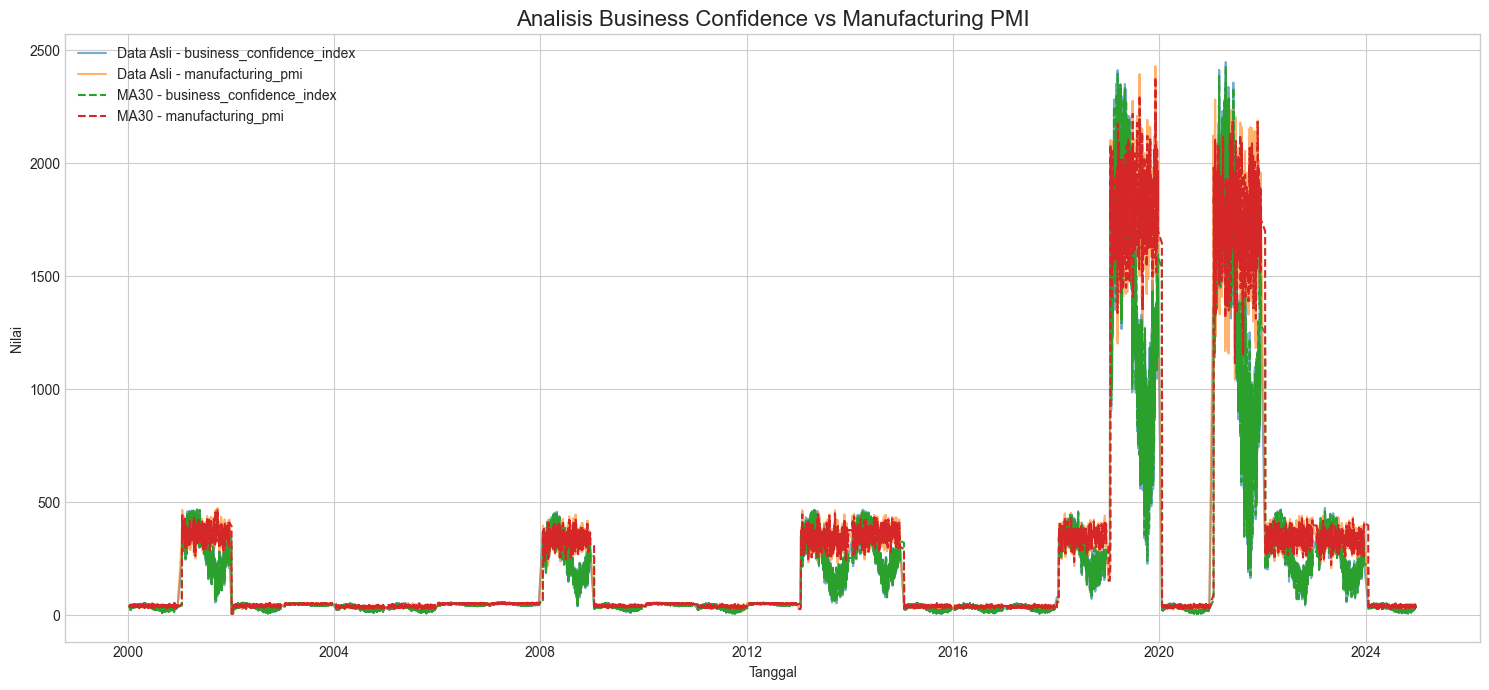


✅ SUKSES! Data yang telah dianalisis disimpan ke business_confidence_index_and_manufacturing_pmi_analyzed.csv


In [2]:
import cv2
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import pytesseract

# --- PENGATURAN UTAMA ---

# Set ke True untuk tes pada satu gambar, set ke False untuk proses semua gambar
DEBUG_MODE = False

# 1. Sesuaikan path ke tesseract jika perlu (untuk Windows)
# pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# 2. Sesuaikan path ke folder data Anda
folder_path = r"C:\Users\LENOVO\Downloads\statexplore\Data\C01\business_confidence_index and manufacturing_pmi"

# 3. Sesuaikan nama file output CSV
output_csv_file = "business_confidence_index_and_manufacturing_pmi_analyzed.csv"

# 4. !! NILAI FALLBACK !! Atur nilai manual jika OCR gagal
FALLBACK_Y_MIN, FALLBACK_Y_MAX = 40, 70

# 5. Sesuaikan rentang warna HSV
var1_name = "business_confidence_index" # Biru
lower_blue = np.array([95, 100, 50])
upper_blue = np.array([130, 255, 255])

var2_name = "manufacturing_pmi" # Oranye
lower_orange = np.array([5, 100, 100])
upper_orange = np.array([25, 255, 255])


# ------------------- FUNGSI-FUNGSI BANTU (TIDAK BERUBAH) -------------------
def preprocess_for_ocr(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    resized = cv2.resize(thresh, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)
    return resized

def extract_year_from_title(title_crop):
    try:
        title_text = pytesseract.image_to_string(title_crop)
        match = re.search(r'\b(20\d{2})\b', title_text)
        if match: return int(match.group(1))
    except: pass
    return None

def extract_yaxis_range(yaxis_crop):
    try:
        processed_yaxis = preprocess_for_ocr(yaxis_crop)
        ocr_text = pytesseract.image_to_string(processed_yaxis, config='--psm 6')
        numbers = [float(num) for num in re.findall(r'(\d+\.?\d*)', ocr_text)]
        if numbers and len(numbers) > 1: return min(numbers), max(numbers), processed_yaxis
    except: pass
    return None, None, None

def extract_series(mask, var_name, plot_h, plot_w, year, y_min, y_max):
    extracted = []
    for x_pixel in range(plot_w):
        y_pixels = np.where(mask[:, x_pixel] > 0)[0]
        if len(y_pixels) > 0:
            y_pixel_avg = int(np.mean(y_pixels))
            value = y_max - ((y_pixel_avg / plot_h) * (y_max - y_min))
            day_of_year = int((x_pixel / plot_w) * 365) + 1
            extracted.append({"Year": year, "DayOfYear": day_of_year, var_name: round(value, 2)})
    return extracted

# ------------------- (BARU) FUNGSI PEMROSESAN DATA -------------------
def process_and_visualize_data(df, title="Hasil Ekstraksi Data"):
    """
    Fungsi ini mengambil DataFrame yang diekstrak, membersihkan, menganalisis,
    dan memvisualisasikannya.
    """
    print("\n[ANALISIS] Memulai pemrosesan data yang diekstrak...")
    
    # Salin agar tidak mengubah dataframe asli
    proc_df = df.copy()

    # 1. Transformasi Data: Membuat kolom 'Date'
    # Menggunakan format '%Y-%j' untuk mengonversi Tahun dan Hari ke-N menjadi tanggal
    proc_df['Date'] = pd.to_datetime(proc_df['Year'].astype(str) + '-' + proc_df['DayOfYear'].astype(str), format='%Y-%j')
    proc_df = proc_df.sort_values(by='Date').set_index('Date')
    print("  -> Kolom 'Date' berhasil dibuat dan dijadikan index.")

    # 2. Pembersihan Data: Mengisi nilai kosong (NaN) dengan interpolasi berbasis waktu
    proc_df.interpolate(method='time', inplace=True)
    # Hapus baris yang mungkin masih NaN di awal atau akhir
    proc_df.dropna(inplace=True)
    print(f"  -> Data kosong diisi menggunakan interpolasi. Sisa data: {len(proc_df)} baris.")

    # 3. Analisis Sederhana: Menghitung Moving Average 30 hari
    for col in proc_df.columns:
        if col not in ['Year', 'DayOfYear']:
             proc_df[f'{col}_MA30'] = proc_df[col].rolling(window=30).mean()
    print("  -> Fitur Moving Average 30 hari (MA30) berhasil ditambahkan.")

    # 4. Visualisasi Hasil Akhir
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 7))

    # Plot data asli
    ax.plot(proc_df.index, proc_df[var1_name], label=f'Data Asli - {var1_name}', alpha=0.6)
    ax.plot(proc_df.index, proc_df[var2_name], label=f'Data Asli - {var2_name}', alpha=0.6)

    # Plot Moving Average
    ax.plot(proc_df.index, proc_df[f'{var1_name}_MA30'], label=f'MA30 - {var1_name}', linestyle='--')
    ax.plot(proc_df.index, proc_df[f'{var2_name}_MA30'], label=f'MA30 - {var2_name}', linestyle='--')

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tanggal')
    ax.set_ylabel('Nilai')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    print("  -> Visualisasi data akhir telah dibuat. Tampilkan plot...")
    plt.show()
    
    return proc_df


# ------------------- KODE UTAMA (DENGAN MODIFIKASI) -------------------
def main():
    # ... (Bagian pembacaan file sama seperti sebelumnya, tidak perlu diubah)
    # Mulai dari sini
    print(f"Memulai proses dari folder: '{folder_path}'")
    try:
        image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".png")])
        if not image_files:
            print(f"❌ KESALAHAN: Tidak ada file .png ditemukan. Periksa path Anda.")
            return
    except FileNotFoundError:
        print(f"❌ KESALAHAN: Folder tidak ditemukan. Periksa path Anda.")
        return

    all_points = []
    files_to_process = image_files[:1] if DEBUG_MODE else image_files
    if DEBUG_MODE:
        print("🛠️ Menjalankan dalam MODE DEBUG: Hanya 1 file akan dianalisis.")

    for filename in files_to_process:
        # ... (Looping dan ekstraksi data sama persis seperti sebelumnya)
        full_path = os.path.join(folder_path, filename)
        img = cv2.imread(full_path)
        if img is None:
            print(f"⚠️ Peringatan: Gagal membaca {filename}, dilewati.")
            continue
            
        h, w, _ = img.shape
        print(f"\n[INFO] Memproses {filename}...")

        title_crop = img[0:int(h*0.1), 0:w]
        yaxis_crop = img[int(h*0.12):int(h*0.9), 0:int(w*0.06)] 

        year = extract_year_from_title(title_crop)
        if year: print(f"  -> Tahun (OCR): {year}")
        else:
            year_match = re.search(r'(\d{4})', filename)
            year = int(year_match.group(1)) if year_match else 0
            print(f"  -> Tahun (Filename): {year}")
            
        y_min, y_max, processed_yaxis_for_debug = extract_yaxis_range(yaxis_crop)
        if y_min is not None and y_max is not None:
            print(f"  -> Sumbu Y (OCR): Min={y_min}, Max={y_max}")
        else:
            y_min, y_max = FALLBACK_Y_MIN, FALLBACK_Y_MAX
            print(f"  -> Sumbu Y (Fallback): Min={y_min}, Max={y_max}")

        plot_area = img[int(h*0.12):int(h*0.9), int(w*0.05):int(w*0.98)]
        plot_h, plot_w, _ = plot_area.shape
        hsv = cv2.cvtColor(plot_area, cv2.COLOR_BGR2HSV)
        mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
        mask_orange = cv2.inRange(hsv, lower_orange, upper_orange)
        data_var1 = extract_series(mask_blue, var1_name, plot_h, plot_w, year, y_min, y_max)
        data_var2 = extract_series(mask_orange, var2_name, plot_h, plot_w, year, y_min, y_max)
        
        print(f"  -> Ditemukan {len(data_var1)} titik data untuk '{var1_name}'")
        print(f"  -> Ditemukan {len(data_var2)} titik data untuk '{var2_name}'")

        if DEBUG_MODE:
            # ... (Bagian Debug Mode tidak berubah)
            plt.figure(figsize=(20, 5)); plt.subplot(1, 4, 1).set_title('1. Area Grafik Asli'); plt.imshow(cv2.cvtColor(plot_area, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.subplot(1, 4, 2).set_title('2. Sumbu Y untuk OCR'); plt.imshow(processed_yaxis_for_debug if processed_yaxis_for_debug is not None else yaxis_crop, cmap='gray'); plt.axis('off'); plt.subplot(1, 4, 3).set_title(f"3. Deteksi '{var1_name}'"); plt.imshow(mask_blue, cmap='gray'); plt.axis('off'); plt.subplot(1, 4, 4).set_title(f"4. Deteksi '{var2_name}'"); plt.imshow(mask_orange, cmap='gray'); plt.axis('off'); plt.suptitle("Visualisasi Mode Debug", fontsize=16); plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
            return
            
        df1 = pd.DataFrame(data_var1); df2 = pd.DataFrame(data_var2)
        if not df1.empty or not df2.empty:
            if not df1.empty and not df2.empty: all_points.append(pd.merge(df1, df2, on=["Year", "DayOfYear"], how="outer"))
            elif not df1.empty: all_points.append(df1)
            else: all_points.append(df2)

    # --- LANGKAH 5: (BARU) Pemrosesan, Analisis, dan Visualisasi Data ---
    if all_points:
        # Gabungkan semua data mentah terlebih dahulu
        raw_df = pd.concat(all_points, ignore_index=True)
        
        # Kirim ke fungsi baru untuk diproses
        analyzed_df = process_and_visualize_data(raw_df, title="Analisis Business Confidence vs Manufacturing PMI")
        
        # Simpan DataFrame yang sudah diolah (dengan kolom Date, MA30, dll)
        analyzed_df.to_csv(output_csv_file)
        print(f"\n✅ SUKSES! Data yang telah dianalisis disimpan ke {output_csv_file}")
    elif not DEBUG_MODE:
        print("\n⚠️ PROSES SELESAI: Tidak ada data mentah yang berhasil diekstrak.")

if __name__ == '__main__':
    main()